For a given galaxy, this notebook will retrieve the Legacy Imaging Surveys cutout of the galaxy.

In [2]:
import os
import requests

from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
'''
import sys
sys.path.insert(1, '{}/desi/DESI_SGA/'.format(os.environ['HOME']))
try:
    from plot_funcs import plot_radec_DESI
except ModuleNotFoundError as e:
    print(e)
''';
import psycopg2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from astropy.coordinates import SkyCoord, match_coordinates_sky

from glob import glob

from scipy.ndimage import gaussian_filter1d

from desispec.io import read_spectra
from desispec.spectra import stack as specstack
from desispec.coaddition import coadd_cameras

# Data

## fuji

In [4]:
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


## SGA

In [7]:
SGA = Table.read('/global/cfs/projectdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## Extract just this galaxy's data

In [10]:
galaxy_to_plot = 'PGC3126144'

# Find the galaxy's SGA_ID
galaxy_sgaid = SGA['SGA_ID'][SGA['GALAXY'] == galaxy_to_plot][0]

# Find all of the observations of this galaxy in the data
galaxy_obs = tfuji[tfuji['SGA_ID'] == galaxy_sgaid]
galaxy_obs

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1070229190868992,210.858547655643,4.87192325434014,26092,sv3,1.14406258402948,0.000118822167634093,0,14.0664672106504,fuji/healpix/sv3/bright/260/26092/redrock-sv3-bright-26092.fits,TFT,19278,210.8585476556428,4.871923254340143
1083423330402304,210.858547655643,4.87192325434014,26092,sv3,1.4358017884114,0.000110223663497119,4,7.64484196156263,fuji/healpix/sv3/dark/260/26092/redrock-sv3-dark-26092.fits,TFT,19278,210.8585476556428,4.871923254340143
1070229190868993,210.859531713976,4.87216798260808,26092,sv3,0.11600554255317,1.91818761856504e-05,0,16.6535585150123,fuji/healpix/sv3/bright/260/26092/redrock-sv3-bright-26092.fits,TFT,19278,210.8595317139761,4.872167982608078
1070229190868994,210.860545593008,4.87242012538817,26092,sv3,0.115979720679715,6.05135432876764e-06,0,700.236421465874,fuji/healpix/sv3/bright/260/26092/redrock-sv3-bright-26092.fits,TFT,19278,210.86054559300837,4.872420125388172
39627902953718333,210.861529652797,4.87266485075211,26092,sv3,0.115668211144625,8.2244674488589e-06,0,979.469165354967,fuji/healpix/sv3/bright/260/26092/redrock-sv3-bright-26092.fits,TFT,19278,210.86152965279655,4.872664850752113
1070229190868995,210.862513713301,4.87290957468562,26092,sv3,0.115523322668871,7.43400066775885e-06,0,569.763811528683,fuji/healpix/sv3/bright/260/26092/redrock-sv3-bright-26092.fits,TFT,19278,210.8625137133014,4.8729095746856155
1083423330402307,210.862513713301,4.87290957468562,26092,sv3,0.115534787878408,4.22734282712008e-06,0,1708.66118872166,fuji/healpix/sv3/dark/260/26092/redrock-sv3-dark-26092.fits,TFT,19278,210.8625137133014,4.8729095746856155
1070229190868996,210.863527594571,4.8731617129997,26092,sv3,0.115494616829675,2.54122205055296e-05,0,11.4446858614683,fuji/healpix/sv3/bright/260/26092/redrock-sv3-bright-26092.fits,TFT,19278,210.86352759457108,4.8731617129997025
1083423330402308,210.863527594571,4.8731617129997,26092,sv3,0.115486296154219,1.18447314556938e-05,0,183.498901769519,fuji/healpix/sv3/dark/260/26092/redrock-sv3-dark-26092.fits,TFT,19278,210.86352759457108,4.8731617129997025


# Legacy Imaging Surveys cutout

In [5]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'SV/cache/fuji_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

## Find the targetid of the center observation

In [11]:
first_digits = np.trunc(galaxy_obs['TARGETID'] * 10**(-np.trunc(np.log10(galaxy_obs['TARGETID'])))).astype(int)

center = galaxy_obs[first_digits == 3]
center

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
39627902953718333,210.861529652797,4.87266485075211,26092,sv3,0.115668211144625,8.2244674488589e-06,0,979.469165354967,fuji/healpix/sv3/bright/260/26092/redrock-sv3-bright-26092.fits,TFT,19278,210.86152965279655,4.872664850752113


## Grab image of galaxy and put the observations on it

SV/cache/fuji_39627902953718333.jpg exists.


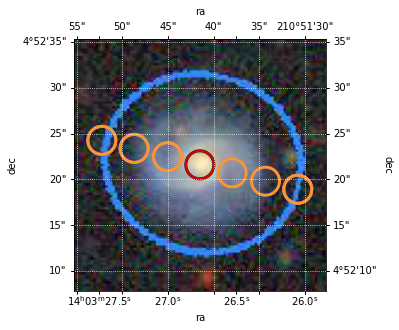

In [18]:
# Padd the image cutout of the galaxy.
# Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
npix = np.minimum(int(1.25 * SGA['D26'][SGA['GALAXY'] == galaxy_to_plot][0]*60/0.262), 512)

img_file, wcs = get_cutout(center['TARGETID'][0], 
                           center['TARGET_RA'][0], 
                           center['TARGET_DEC'][0], 
                           size=npix, 
                           verbose=True)
img = mpl.image.imread(img_file)

fig1 = plt.figure(figsize=(7,5))

ax = fig1.add_subplot(111, projection=wcs)
ax.imshow(np.flip(img, axis=0))
ax.set(xlabel='ra', ylabel='dec')
#ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

for tft in galaxy_obs:
    ra, dec = tft['RA'], tft['DEC']

    edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), 107./70 * u.arcsec,
                         edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), 107./70 * u.arcsec,
                         edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

# Add the location of the DESI fibers.
# SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
r1 = SphericalCircle((center['RA'][0] * u.deg, center['DEC'][0] * u.deg), 107./70 * u.arcsec,
                     edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                     transform=ax.get_transform('icrs'))
r2 = SphericalCircle((center['RA'][0] * u.deg, center['DEC'][0] * u.deg), 107./70 * u.arcsec,
                     edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                     transform=ax.get_transform('icrs'))
ax.add_patch(r1)
ax.add_patch(r2)

fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)

plt.savefig('SV/cache/fuji_' + galaxy_to_plot + '.png');